In [36]:
# Mount Drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import torch
import string

In [38]:
# to load in from json file
# data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/implementation/News_Category_Dataset_v2.json", lines=True)

# data = data.dropna()
# data = data.sample(n=1000)

# data['text'] = data.headline + data.short_description
# text = data['text']
# text.to_string()
# json = ''
# for i in text:
#   i = i + '\n'
#   json += i

# text = json
# print(len(text.split("\n")))
# #print(new)

In [39]:
# to load in from text file
lines = ''
with open('/content/drive/MyDrive/implementation/stu1.txt') as f:
    lines = f.readlines()

text_file = ''
for i in lines:
  i = i + '\n'
  text_file += i

text = text_file
# print(text)
# print(len(text.split("\n")))
# print(text)

In [40]:
# to use whatever text you want
# text = (
#         'Hello, how are you? I am Romeo.\n'
#         'Hello, Romeo My name is Juliet. Nice to meet you.'
#         'Nice meet you too. How are you today?\n'
#         'Great. My baseball team won the competition.\n'
#         'Oh Congratulations, Juliet\n'
#         'Thanks you Romeo'
#     )
# print(text)
torch.cuda.empty_cache()

In [41]:
text = text.lower()
text = text.translate(str.maketrans('', '', string.punctuation))
sentences = text.split('\n')
sentences = [x for x in sentences if x] # get rid of empty lists
word_list = list(set(" ".join(sentences).split()))
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}

for i, w in enumerate(word_list):
    word_dict[w] = i + 4
number_dict = {i: w for i, w in enumerate(word_dict)} # mapping unique words to numbers
vocab_size = len(word_dict) # number of unique words + 4

token_list = [] # list of list containing token numbers for each word in each sentence
for sentence in sentences: 
    arr = [word_dict[s] for s in sentence.split()]
    # if arr != []:
    token_list.append(arr)

print(number_dict)
print(vocab_size)
print(token_list)

{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'ocean', 5: 'clenched', 6: 'here', 7: 'speaking', 8: 'judicial', 9: 'past', 10: 'deeply', 11: 'gorse', 12: 'least', 13: 'incredible', 14: 'colleague', 15: 'compelled', 16: 'sympathies', 17: 'knocked', 18: 'walks', 19: 'into', 20: 'consented', 21: 'swinging', 22: 'painful', 23: 'policeman', 24: 'whom', 25: 'grime', 26: 'tampered', 27: 'nocturnal', 28: 'moments', 29: 'sorelystricken', 30: 'objected', 31: 'retreating', 32: 'hop', 33: 'venture', 34: 'town', 35: 'reason', 36: 'lead', 37: 'rumour', 38: 'befell', 39: 'pallor', 40: 'hand', 41: 'fellows', 42: 'called', 43: 'village', 44: 'tragedy', 45: 'furtive', 46: 'brutal', 47: 'unshaven', 48: 'reduced', 49: 'postbag', 50: 'torrent', 51: 'true', 52: 'aha', 53: 'made', 54: 'blossoms', 55: 'yet', 56: 'evident', 57: 'entrances', 58: 'evening', 59: 'showed', 60: 'inform', 61: 'doctor', 62: 'roughhaired', 63: 'mentioned', 64: 'knees', 65: 'undertake', 66: 'dramatic', 67: 'committed', 68: 'hills

In [42]:
# parameters
maxlen = 500 # maximum of length
batch_size = 4 # batch size 
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2 

In [43]:
def make_batch():
    batch = []
    positive = 0
    negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences))
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]

        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]

        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence

        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
        # else:
        #     batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
        #     negative += 1
    return batch

In [44]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [45]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [46]:
batch = make_batch()

In [47]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

In [48]:
get_attn_pad_mask(input_ids, input_ids)[0][0], input_ids[0]

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [49]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [50]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

In [51]:
emb = Embedding()
embeds = emb(input_ids, segment_ids)

attenM = get_attn_pad_mask(input_ids, input_ids)

SDPA= ScaledDotProductAttention()(embeds, embeds, embeds, attenM)

S, A = SDPA

#print('Masks',masks[0][0])
# print()
# print('Scores: ', S[0][0],'\n\nAttention M: ', A[0][0])

In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]


In [53]:
emb = Embedding()
embeds = emb(input_ids, segment_ids)

attenM = get_attn_pad_mask(input_ids, input_ids)

MHA = MultiHeadAttention()(embeds, embeds, embeds, attenM)

Output, A = MHA

# A[0][0]

In [54]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # self.fci1 = nn.Linear(3068, 600)
        self.fci1 = nn.Linear(d_ff, 600)
        self.fci2 = nn.Linear(600, 500)
        self.fci3 = nn.Linear(500, 600)
        self.fci4 = nn.Linear(600, 1000)
        self.fci5 = nn.Linear(1000, d_ff)   

        self.conv = nn.Conv2d(4, 10, kernel_size=1)
        self.conv2 = nn.Conv2d(10, 4, kernel_size=1)
        self.conv3 = nn.Conv2d(4, 4, kernel_size=1)
        self.conv4 = nn.Conv2d(4, 4, kernel_size=1)
        self.conv5 = nn.Conv2d(4, 4, kernel_size=2)     

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        x = gelu(self.fc1(x))
        # # # convoltional layers
        # x = self.conv(x)        
        # # print(x.size())
        # x = gelu(x)
        # x = self.conv2(x)        
        # # print(x.size())
        # x = gelu(x)
        # x = self.conv3(x)  
        # x = gelu(x)      

        # linear intermediate layers
        x = gelu(self.fci1(x))
        x = gelu(self.fci2(x))
        x = gelu(self.fci3(x))
        x = gelu(self.fci4(x))
        x = gelu(self.fci5(x))
        #output layer
        x = gelu(self.fc2(x))
        
        
        return x


In [55]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [56]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

In [57]:
from torch.cuda import is_available
device = "cuda" if torch.cuda.is_available else "cpu"
#device = "cpu"
print(device)

cuda


In [61]:
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

train_losses_mask = []
train_losses_nsp = []
train_losses_total = []

for epoch in range(10):
    optimizer.zero_grad()
    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    train_losses_mask.append(loss_lm)
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    train_losses_nsp.append(loss_clsf)
    loss = loss_lm + loss_clsf
    train_losses_total.append(loss)
    if (epoch + 1) % 2 == 0:
        print('Epoch:', '%d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 2 loss = 60.096581
Epoch: 4 loss = 79.762764
Epoch: 6 loss = 67.150238
Epoch: 8 loss = 219.833878
Epoch: 10 loss = 142.428604


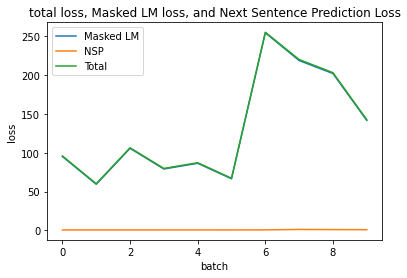

In [62]:
import matplotlib.pyplot as plt

mask_plt = []
for x in train_losses_mask:
  y = x.detach().numpy()
  mask_plt.append(y)

nsp_plt = []
for x in train_losses_nsp:
  y = x.detach().numpy()
  nsp_plt.append(y)

total_plt = []
for x in train_losses_total:
  y = x.detach().numpy()
  total_plt.append(y)

plt.plot(mask_plt, label='Masked Language Model loss')
plt.plot(nsp_plt, label='Next Sentence Prediction Loss')
plt.plot(total_plt, label='Total loss')
plt.xlabel("batch")
plt.ylabel("loss")
plt.title("total loss, Masked LM loss, and Next Sentence Prediction Loss")
plt.legend(['Masked LM','NSP','Total'])
plt.show()

In [63]:
n = 2
mask_corr = 0
nsp_corr = 0
total_nsp = 0
total_mask = 0
print("First ", n, " outputs for qualitative analysis")
neg_average = 0
pos_average = 0

for b in batch:
  
  total_nsp += 1
  total_mask += 1
  
  # Predict mask tokens and isNext
  input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(b))

  logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)

  # if (n != 0):
  #   print(logits_lm.data.max(2))
  #   print(logits_clsf.data.max(1)[0].data.numpy()[0])

  torf = logits_clsf.data.max(1)[0].data.numpy()[0]
  logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
  

  if (not(torf)):
    neg_average += neg_average - logits_clsf
  if (torf):
    pos_average += pos_average - logits_clsf

  if ((logits_clsf < pos_average) and torf):
    logits_clsf = False
  elif ((logits_clsf > pos_average) and torf):
    logits_clsf = True
  elif ((logits_clsf > neg_average) and not(torf)):
    logits_clsf = False
  else:
    logits_clsf = True

  logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
  # logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]

  if (n != 0):
    n -= 1

    sentence = []
    j = 0
    for w in input_ids[0]:
      trans = number_dict[w.item()]
      if (trans == '[MASK]'):
        sentence.append(number_dict[int(masked_tokens[0][j])])
        j += 1
      elif (trans != '[PAD]'):
        sentence.append(trans)
    print('Actual Sentence')
    print(sentence)

    print('Encoded Sentence')
    print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

    sentence = []
    j = 0
    for w in input_ids[0]:
      trans = number_dict[w.item()]
      if (trans == '[MASK]'):
        sentence.append(number_dict[logits_lm[j]])
        j += 1
      elif (trans != '[PAD]'):
        sentence.append(trans)
    print('Predicted Sentence')
    print(sentence)

    masks_pred = []
    for x in logits_lm:
      masks_pred.append(x)
    masks_act = []
    for x in masked_tokens[0]:
      masks_act.append(int(x))
    print('masked tokens list : ',masks_act)
    print('predict masked tokens list : ',masks_pred)
  
    print('isNext : ', bool(isNext))
    print('predict isNext : ', bool(logits_clsf))
    print("")

  for i in range(len(logits_lm)):
    pos = masked_tokens[0][i]
    ppos = logits_lm[i]
    if pos == ppos:
      if pos != 0:
        mask_corr += 1

  if isNext == logits_clsf:
    nsp_corr += 1


mask_acc = float(mask_corr/total_mask)
nsp_acc = float(nsp_corr/total_nsp)

print('Masked Tokens Prediction Accuracy: ', mask_acc)
print('Next Sentence Prediciton Accuracy: ', nsp_acc)

First  2  outputs for qualitative analysis
Actual Sentence
['[CLS]', 'avail', 'ourselves', 'of', 'his', 'services', 'situation', 'from', 'going', 'to', 'the', 'inn', 'mr', '[SEP]', 'by', 'a', 'singular', 'happy', 'and', 'chance', 'we', 'far', 'able', 'to', 'some', 'extent', 'to', 'check', '[SEP]']
Encoded Sentence
['[CLS]', 'avail', 'ourselves', 'of', 'his', 'services', 'situation', 'from', 'going', 'to', 'the', 'inn', 'mr', '[SEP]', 'by', 'a', 'singular', '[MASK]', '[MASK]', 'chance', 'we', '[MASK]', 'able', 'to', 'some', 'extent', 'to', 'check', '[SEP]']
Predicted Sentence
['[CLS]', 'avail', 'ourselves', 'of', 'his', 'services', 'situation', 'from', 'going', 'to', 'the', 'inn', 'mr', '[SEP]', 'by', 'a', 'singular', 'place', 'place', 'chance', 'we', 'place', 'able', 'to', 'some', 'extent', 'to', 'check', '[SEP]']
masked tokens list :  [1286, 2202, 144, 1216, 0]
predict masked tokens list :  [1532, 1532, 1532, 1532, 1532]
isNext :  False
predict isNext :  True

Actual Sentence
['[CLS]'